In [1]:
import numpy as np # линейная алгебра
import pandas as pd # обработка данных, ввод-вывод CSV-файла (например, pd.read_csv)

## Про набор данных
Это набор данных классификации текстовых документов, который содержит 2225 текстовых данных и пять категорий документов. Пять категорий — это политика, спорт, технологии, развлечения и бизнес. Мы можем использовать этот набор данных для классификации документов и кластеризации документов.

> **Labels**
> * Политика = 0
> * Спорт = 1
> * Технологии = 2
> * Развлечения =3
> * Бизнес = 4

### Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import re
import string
import nltk
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
nltk.download("stopwords")
from pymystem3 import Mystem
from nltk.util import ngrams
import snowballstemmer
from rutermextract import TermExtractor
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /Users/a12/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Выбор методов очистки текста
Для получения наивысшей accuracy выберем оптимальный метод очистки текста.
    
Всего рассмотрим 6 методов очистки текста:
1. Без приведенных ниже методов
2. Лемматизация
3. Стемминг
4. Би-граммы
5. 3-граммы
6. 4-граммы

Также при рассмотрении каждого метода очистки текста будут применяться стандартные процедуры очистки текста (удаление всех символов кроме букв, приведение к нижнему регистру и удаление стоп-слов)

In [3]:
np.random.seed(42)
torch.manual_seed(42)

In [4]:
df = pd.read_csv("data_kaggle_ru.csv")
df.head()

,Unnamed: 0,text,label,data_source,url_data_source
0,0,Бюджет для создания условий для выборов\n \n Г...,0,KAGGLE_DATASET,https://www.kaggle.com/datasets/sunilthite/tex...
1,1,Армейские вожди в составе полков\n \n Ожидаетс...,0,KAGGLE_DATASET,https://www.kaggle.com/datasets/sunilthite/tex...
2,2,Говард отрицает разбивку на удостоверения личн...,0,KAGGLE_DATASET,https://www.kaggle.com/datasets/sunilthite/tex...
3,3,Наблюдатели за выборами в Соединенном Королевс...,0,KAGGLE_DATASET,https://www.kaggle.com/datasets/sunilthite/tex...
4,4,Килрой назвал выборное место\n \n Бывший орган...,0,KAGGLE_DATASET,https://www.kaggle.com/datasets/sunilthite/tex...


In [5]:
df = df[["text", "label"]]
df = df.rename(columns={'text':'Text','label':'Label'})

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    2225 non-null   object
 1   Label   2225 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.9+ KB


In [7]:
df.isnull().sum()

Text     0
Label    0
dtype: int64

In [8]:
df.duplicated().sum()

100

In [9]:
df = df.drop_duplicates()
df.shape

(2125, 2)

Label
0    403
1    505
2    345
3    369
4    503
Name: count, dtype: int64


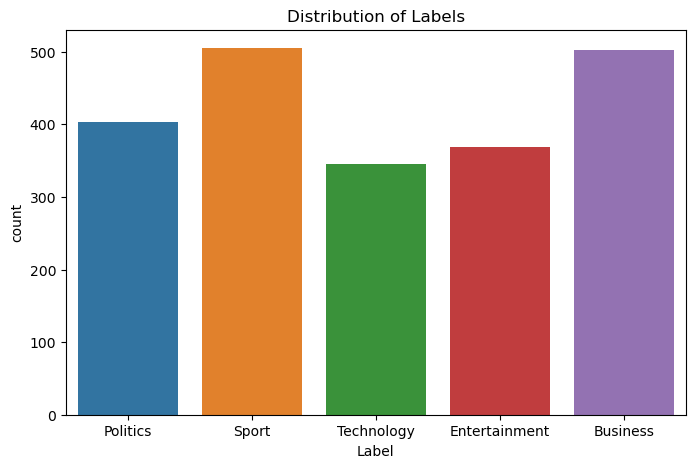

In [10]:
print(df.Label.value_counts().sort_index())
fig, ax=plt.subplots(figsize=(8,5))
sns.barplot(x=df.Label.value_counts().index, y=df.Label.value_counts(), ax=ax)
ax.set_title("Distribution of Labels")
ax.set_xticklabels(["Politics", "Sport", "Technology", "Entertainment", "Business"])
plt.show()

In [11]:
df.Text[0]

'Бюджет для создания условий для выборов\n \n Гордон Браун постарается поставить экономику в центр предложения лейбористов на третий срок, когда он представит свой девятый бюджет в 12:30 по Гринвичу. Ожидается, что он подчеркнет важность сохранения экономической стабильности при низких уровнях безработицы и процентных ставок. Ожидается, что канцлер заморозит пошлину на бензин и повысит порог гербового тарифа с 60 000 фунтов стерлингов. Но консерваторы и Либ Демс настаивают на том, что избиратели сталкиваются с более высокими налогами и с большим количеством проверок материального положения в рамках трудового законодательства.\n \n Казначейские чиновники сказали, что не будет предвыборной передачи, но мистеру Брауну, как предполагается, осталось около 2 млрд. фунтов стерлингов.\n \n - повышение порога гербового сбора с 60 000 фунтов стерлингов; \n  - Заморозка бензина \n  - расширение системы налоговых кредитов для более бедных семей; \n  - Возможная помощь пенсионерам: повышение порого

## Очистка текста (1 метод - без лемматизации, стемминга и n-грамм)

In [12]:
def clean_text1(text):
    text = re.sub('\n', " ", text)
    text = re.sub(r'[^а-яА-Я]', " ", text)
    text = re.sub(r'\s+', " ", text)
    text = text.lower()
    text = text.split()
    text = [j for j in text if len(j) > 1]    
    text = [i for i in text if not i in set(stopwords.words("russian"))]
    text = " ".join(text)
    return text

df["cleaned_text"] = df["Text"].apply(clean_text1)

In [13]:
df.head()

,Text,Label,cleaned_text
0,Бюджет для создания условий для выборов\n \n Г...,0,бюджет создания условий выборов гордон браун п...
1,Армейские вожди в составе полков\n \n Ожидаетс...,0,армейские вожди составе полков ожидается военн...
2,Говард отрицает разбивку на удостоверения личн...,0,говард отрицает разбивку удостоверения личност...
3,Наблюдатели за выборами в Соединенном Королевс...,0,наблюдатели выборами соединенном королевстве м...
4,Килрой назвал выборное место\n \n Бывший орган...,0,килрой назвал выборное место бывший организато...


## Статистика по тексту

In [14]:
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

df["text_length"] = df["cleaned_text"].apply(lambda x: len(str(x)))

df["stopwords_count"] = df["Text"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("russian"))]))

df["punct_count"] = df["Text"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["caps_count"] = df["Text"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df.head()

,Text,Label,cleaned_text,word_count,text_length,stopwords_count,punct_count,caps_count
0,Бюджет для создания условий для выборов\n \n Г...,0,бюджет создания условий выборов гордон браун п...,343,2983,108,86,57
1,Армейские вожди в составе полков\n \n Ожидаетс...,0,армейские вожди составе полков ожидается военн...,288,2559,106,83,46
2,Говард отрицает разбивку на удостоверения личн...,0,говард отрицает разбивку удостоверения личност...,331,2837,123,109,63
3,Наблюдатели за выборами в Соединенном Королевс...,0,наблюдатели выборами соединенном королевстве м...,340,3089,131,81,56
4,Килрой назвал выборное место\n \n Бывший орган...,0,килрой назвал выборное место бывший организато...,274,2274,106,96,109


In [15]:
grouped_text = df.groupby("Label").agg({"word_count": "mean",
                                        "text_length": "mean",
                                        "stopwords_count": "mean",
                                        "punct_count": "mean",
                                        "caps_count": "mean"})
grouped_text = grouped_text.reset_index(drop=True)
grouped_text

,word_count,text_length,stopwords_count,punct_count,caps_count
0,279.034739,2404.538462,111.652605,88.933002,60.119107
1,182.976238,1447.794059,82.200000,68.780198,63.982178
2,297.939130,2577.060870,113.455072,98.449275,72.304348
3,191.439024,1538.230352,72.604336,66.910569,67.260163
4,209.658052,1794.763419,72.391650,68.817097,55.952286


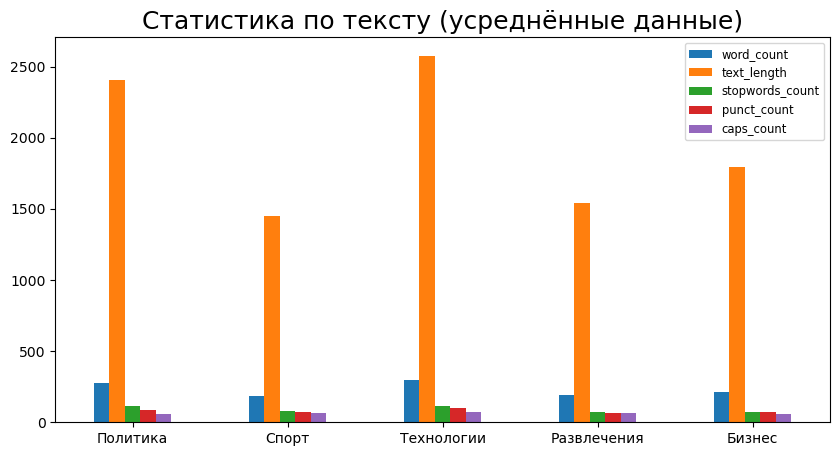

In [16]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_text.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])
ax.set_title("Статистика по тексту (усреднённые данные)", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

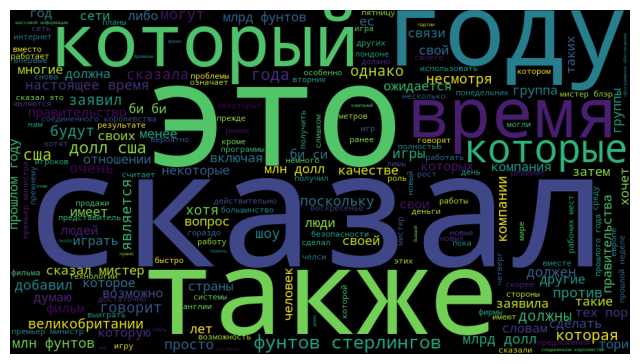

In [17]:
all_cleaned_text = " ".join(df["cleaned_text"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_text)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

## CountVectorizer

In [18]:
count_vec = CountVectorizer(max_features=5000)
count_array = count_vec.fit_transform(df["cleaned_text"]).toarray()
df_count_vec = pd.DataFrame(count_array, columns=count_vec.get_feature_names_out())
df_count_vec = df_count_vec.reset_index(drop=True)
df_count_vec.head()

,абсолютно,аварии,августа,августе,авиакомпании,авиакомпаний,авиакомпания,авиатор,австралии,австралийский,...,ян,январе,января,янг,японии,япония,японская,японский,ярдов,ясно
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [19]:
df1 = df.iloc[:, [1,3,4,5,6,7]]
df1 = df1.reset_index(drop=True)
df1.head()

,Label,word_count,text_length,stopwords_count,punct_count,caps_count
0,0,343,2983,108,86,57
1,0,288,2559,106,83,46
2,0,331,2837,123,109,63
3,0,340,3089,131,81,56
4,0,274,2274,106,96,109


In [20]:
df_nlp = pd.concat([df1, df_count_vec], axis=1)
df_nlp.head()

,Label,word_count,text_length,stopwords_count,punct_count,caps_count,абсолютно,аварии,августа,августе,...,ян,январе,января,янг,японии,япония,японская,японский,ярдов,ясно
0,0,343,2983,108,86,57,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,288,2559,106,83,46,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,331,2837,123,109,63,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,340,3089,131,81,56,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,274,2274,106,96,109,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## RandomUnderSampler

In [21]:
y = df_nlp["Label"]
X = df_nlp.drop("Label", axis=1)

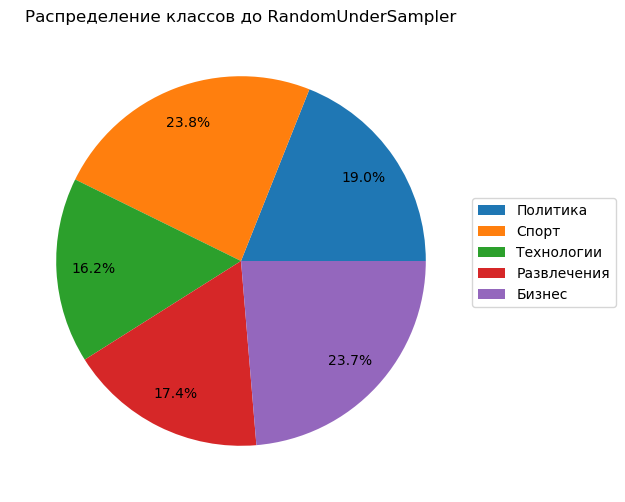

In [22]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов до RandomUnderSampler")
plt.show()

In [23]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

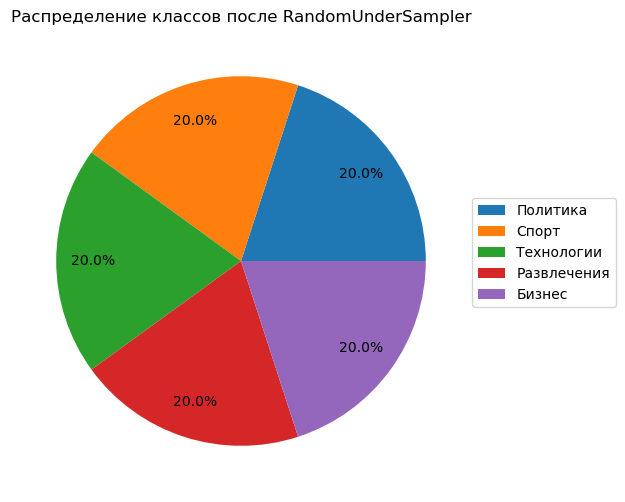

In [24]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов после RandomUnderSampler")
plt.show()

In [25]:
print(X.shape)
print(y.shape)

(1725, 5005)
(1725,)


### train/test - разделение

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Стандартизация

In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Модели

In [28]:
#######  Logistic Regression  #######
log = LogisticRegression().fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

#######  RandomForest  #######
rf = RandomForestClassifier().fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#######  XGB Classifier  #######
xgb = XGBClassifier().fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

#######  LGBM Classifier  #######
lgbm = LGBMClassifier().fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

#######  CatBoost Classifier  #######
catb = CatBoostClassifier(verbose=False).fit(X_train_scaled, y_train)
y_pred_catb = catb.predict(X_test_scaled)

#######  PyTorch  #######
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_size = X_train_tensor.shape[1]
hidden_size = 64
num_classes = len(np.unique(y_train))
learning_rate = 0.001
num_epochs = 50

model = NeuralNetwork(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
y_pred_pytorch = predicted.numpy()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10380
[LightGBM] [Info] Number of data points in the train set: 1207, number of used features: 2001
[LightGBM] [Info] Start training from score -1.574432
[LightGBM] [Info] Start training from score -1.644855
[LightGBM] [Info] Start training from score -1.598725
[LightGBM] [Info] Start training from score -1.611096
[LightGBM] [Info] Start training from score -1.619430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


### Расчёт accuracy

In [29]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catb = accuracy_score(y_test, y_pred_catb)
accuracy_pytorch = accuracy_score(y_test, y_pred_pytorch)

## Результаты моделей

[0.9633204633204633, 0.9324324324324325, 0.9227799227799228, 0.9459459459459459, 0.944015444015444, 0.9652509652509652]


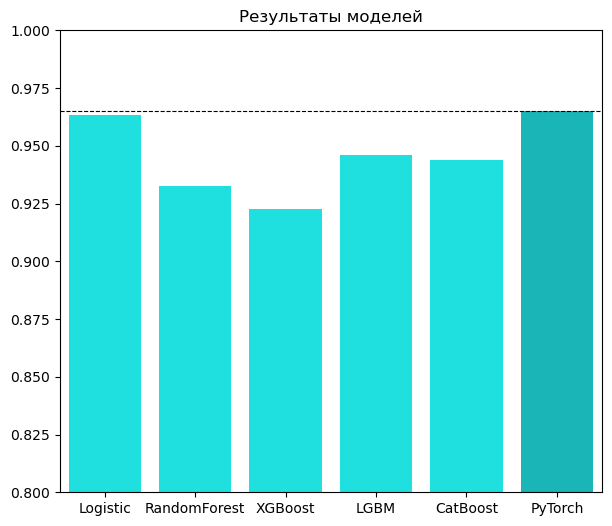

In [30]:
accuracy_list1 = [accuracy_log, accuracy_rf, accuracy_xgb, accuracy_lgbm, accuracy_catb, accuracy_pytorch]
fig, ax=plt.subplots(figsize=(7,6))
cols = ["aqua" if i < (max(accuracy_list1)) else "darkturquoise" for i in accuracy_list1]
sns.barplot(x=np.arange(0,6), y=accuracy_list1, ax=ax, palette=cols)
plt.ylim(0.8, 1)
plt.title("Результаты моделей")
plt.axhline(accuracy_pytorch, lw=0.8, ls="--", color="k")
ax.set_xticklabels(["Logistic", "RandomForest", "XGBoost", "LGBM", "CatBoost", "PyTorch"])
print(accuracy_list1)
plt.show()

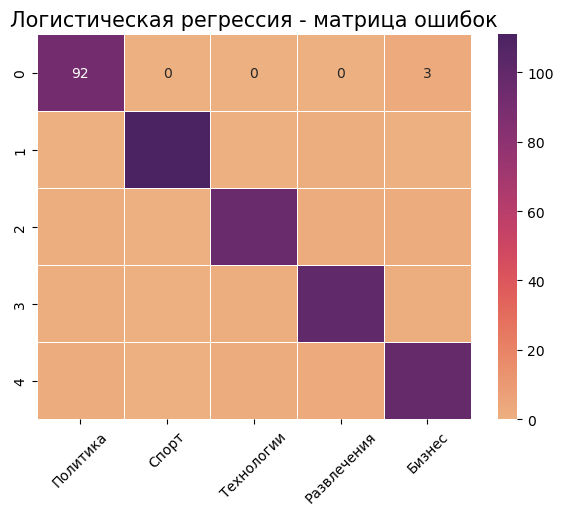

In [31]:
fig, ax=plt.subplots(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, linewidths=0.4, cmap="flare", fmt='.3g', ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], rotation=45)
ax.set_title("Логистическая регрессия - матрица ошибок", fontsize=15)
plt.show()

In [32]:
print(f"############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############\n\n {classification_report(y_test, y_pred_log)}")

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############

               precision    recall  f1-score   support

           0       0.96      0.97      0.96        95
           1       1.00      0.99      1.00       112
           2       0.97      0.95      0.96       101
           3       0.94      0.97      0.96       104
           4       0.94      0.93      0.94       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



## Самое важное для LGBM

In [33]:
df_feature_importance = pd.DataFrame(lgbm.feature_importances_, columns=["feature_importance"])
df_feature_importance["features"] = df_nlp.columns[1:]
df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
df_feature_importance.head()

,feature_importance,features
0,541,text_length
1,517,caps_count
2,438,stopwords_count
3,328,punct_count
4,256,word_count


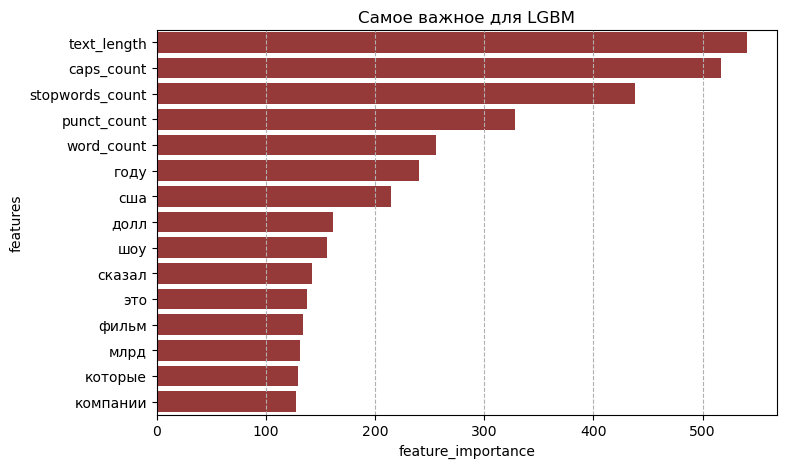

In [34]:
plt.figure(figsize=(8,5))
sns.barplot(x=df_feature_importance.feature_importance[:15], y=df_feature_importance.features[:15], color="brown")
plt.title("Самое важное для LGBM")
plt.grid(axis="x", ls="--")
plt.show()

**_Результаты рейтинга, приведенные выше, объясняют важность статистики слов._**

## Очистка текста (2 метод - лемматизация)

In [35]:
df = pd.read_csv("data_kaggle_ru.csv")
df = df[["text", "label"]]
df = df.rename(columns={'text':'Text','label':'Label'})
df = df.drop_duplicates()

def clean_text2(text):
    text = re.sub('\n', " ", text)
    text = re.sub(r'[^а-яА-Я]', " ", text)
    text = re.sub(r'\s+', " ", text)
    text = text.lower()
    text = text.split()
    text = [j for j in text if len(j) > 1]    
    text = [i for i in text if not i in set(stopwords.words("russian"))]
    mystem = Mystem()
    text = [mystem.lemmatize(word)[0] for word in text]
    text = " ".join(text)
    return text

df["cleaned_text"] = df["Text"].apply(clean_text2)

In [36]:
df.head()

,Text,Label,cleaned_text
0,Бюджет для создания условий для выборов\n \n Г...,0,бюджет создание условие выбор гордон браун пос...
1,Армейские вожди в составе полков\n \n Ожидаетс...,0,армейский вождь состав полк ожидаться военный ...
2,Говард отрицает разбивку на удостоверения личн...,0,говард отрицать разбивка удостоверение личност...
3,Наблюдатели за выборами в Соединенном Королевс...,0,наблюдатель выборы соединять королевство минис...
4,Килрой назвал выборное место\n \n Бывший орган...,0,килрой называть выборный место бывший организа...


## Статистика по тексту

In [37]:
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

df["text_length"] = df["cleaned_text"].apply(lambda x: len(str(x)))

df["stopwords_count"] = df["Text"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("russian"))]))

df["punct_count"] = df["Text"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["caps_count"] = df["Text"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df.head()

,Text,Label,cleaned_text,word_count,text_length,stopwords_count,punct_count,caps_count
0,Бюджет для создания условий для выборов\n \n Г...,0,бюджет создание условие выбор гордон браун пос...,343,2928,108,86,57
1,Армейские вожди в составе полков\n \n Ожидаетс...,0,армейский вождь состав полк ожидаться военный ...,288,2521,106,83,46
2,Говард отрицает разбивку на удостоверения личн...,0,говард отрицать разбивка удостоверение личност...,331,2867,123,109,63
3,Наблюдатели за выборами в Соединенном Королевс...,0,наблюдатель выборы соединять королевство минис...,340,3014,131,81,56
4,Килрой назвал выборное место\n \n Бывший орган...,0,килрой называть выборный место бывший организа...,274,2269,106,96,109


In [38]:
grouped_text = df.groupby("Label").agg({"word_count": "mean",
                                        "text_length": "mean",
                                        "stopwords_count": "mean",
                                        "punct_count": "mean",
                                        "caps_count": "mean"})
grouped_text = grouped_text.reset_index(drop=True)
grouped_text

,word_count,text_length,stopwords_count,punct_count,caps_count
0,279.034739,2380.692308,111.652605,88.933002,60.119107
1,182.976238,1446.796040,82.200000,68.780198,63.982178
2,297.939130,2543.542029,113.455072,98.449275,72.304348
3,191.439024,1524.146341,72.604336,66.910569,67.260163
4,209.658052,1768.914513,72.391650,68.817097,55.952286


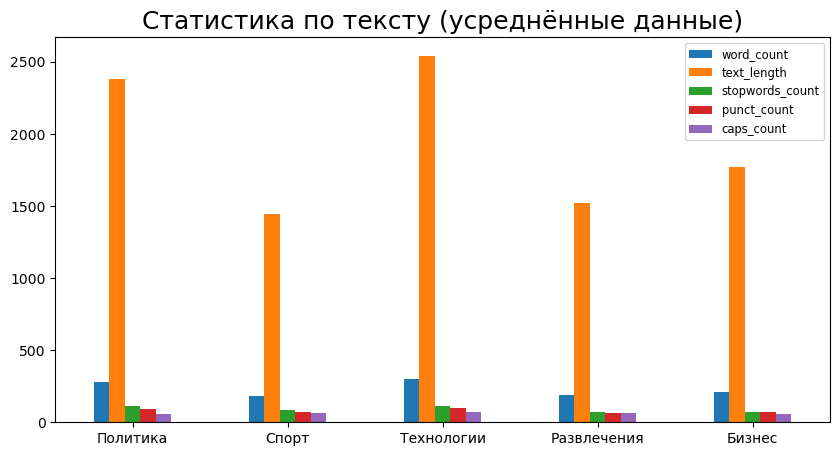

In [39]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_text.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])
ax.set_title("Статистика по тексту (усреднённые данные)", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

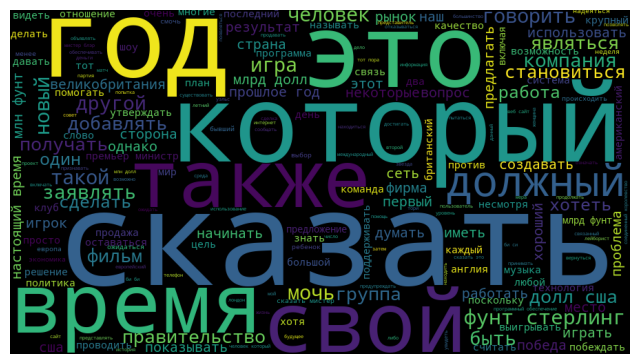

In [40]:
all_cleaned_text = " ".join(df["cleaned_text"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_text)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

## CountVectorizer

In [41]:
count_vec = CountVectorizer(max_features=5000)
count_array = count_vec.fit_transform(df["cleaned_text"]).toarray()
df_count_vec = pd.DataFrame(count_array, columns=count_vec.get_feature_names_out())
df_count_vec = df_count_vec.reset_index(drop=True)
df_count_vec.head()

,аборт,абсолютно,абсолютный,авария,август,авиакомпания,авиатор,авиация,авива,австралийский,...,ярд,яркий,ярлык,ярмарка,ясно,ясный,яху,ячвили,ячейка,ящик
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [42]:
df1 = df.iloc[:, [1,3,4,5,6,7]]
df1 = df1.reset_index(drop=True)
df1.head()

,Label,word_count,text_length,stopwords_count,punct_count,caps_count
0,0,343,2928,108,86,57
1,0,288,2521,106,83,46
2,0,331,2867,123,109,63
3,0,340,3014,131,81,56
4,0,274,2269,106,96,109


In [43]:
df_nlp = pd.concat([df1, df_count_vec], axis=1)
df_nlp.head()

,Label,word_count,text_length,stopwords_count,punct_count,caps_count,аборт,абсолютно,абсолютный,авария,...,ярд,яркий,ярлык,ярмарка,ясно,ясный,яху,ячвили,ячейка,ящик
0,0,343,2928,108,86,57,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,288,2521,106,83,46,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,331,2867,123,109,63,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,340,3014,131,81,56,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,274,2269,106,96,109,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


## RandomUnderSampler

In [44]:
y = df_nlp["Label"]
X = df_nlp.drop("Label", axis=1)

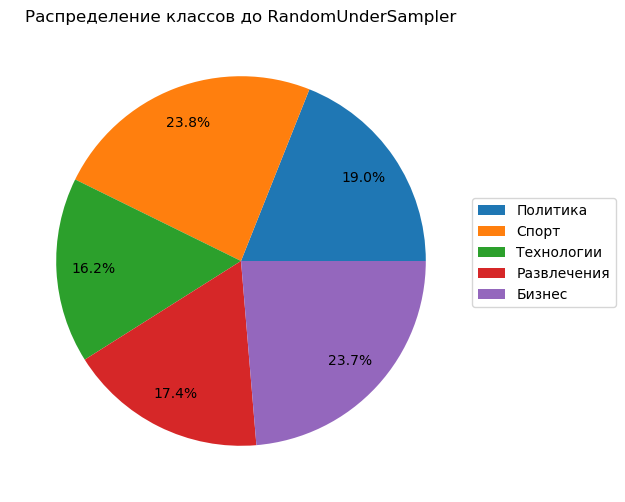

In [45]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов до RandomUnderSampler")
plt.show()

In [46]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

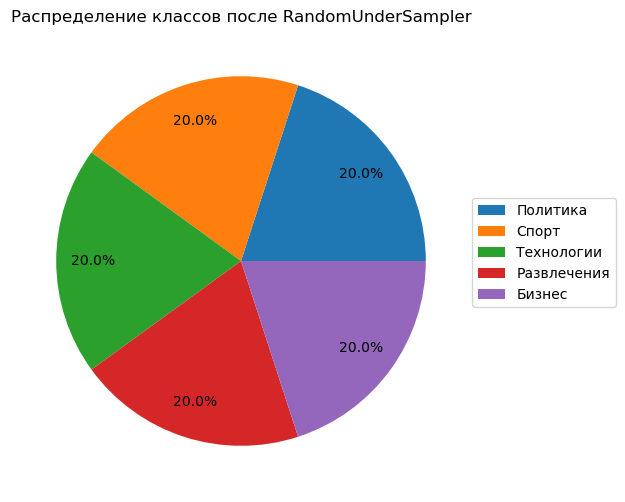

In [47]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов после RandomUnderSampler")
plt.show()

In [48]:
print(X.shape)
print(y.shape)

(1725, 5005)
(1725,)


### train/test - разделение

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Стандартизация

In [50]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Модели

In [51]:
#######  Logistic Regression  #######
log = LogisticRegression().fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

#######  RandomForest  #######
rf = RandomForestClassifier().fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#######  XGB Classifier  #######
xgb = XGBClassifier().fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

#######  LGBM Classifier  #######
lgbm = LGBMClassifier().fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

#######  CatBoost Classifier  #######
catb = CatBoostClassifier(verbose=False).fit(X_train_scaled, y_train)
y_pred_catb = catb.predict(X_test_scaled)

#######  PyTorch  #######
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_size = X_train_tensor.shape[1]
hidden_size = 64
num_classes = len(np.unique(y_train))
learning_rate = 0.001
num_epochs = 50

model = NeuralNetwork(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
y_pred_pytorch = predicted.numpy()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11678
[LightGBM] [Info] Number of data points in the train set: 1207, number of used features: 2027
[LightGBM] [Info] Start training from score -1.574432
[LightGBM] [Info] Start training from score -1.644855
[LightGBM] [Info] Start training from score -1.598725
[LightGBM] [Info] Start training from score -1.611096
[LightGBM] [Info] Start training from score -1.619430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


### Расчёт accuracy

In [52]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catb = accuracy_score(y_test, y_pred_catb)
accuracy_pytorch = accuracy_score(y_test, y_pred_pytorch)

## Результаты моделей

[0.9517374517374517, 0.9459459459459459, 0.9401544401544402, 0.9478764478764479, 0.9401544401544402, 0.9594594594594594]


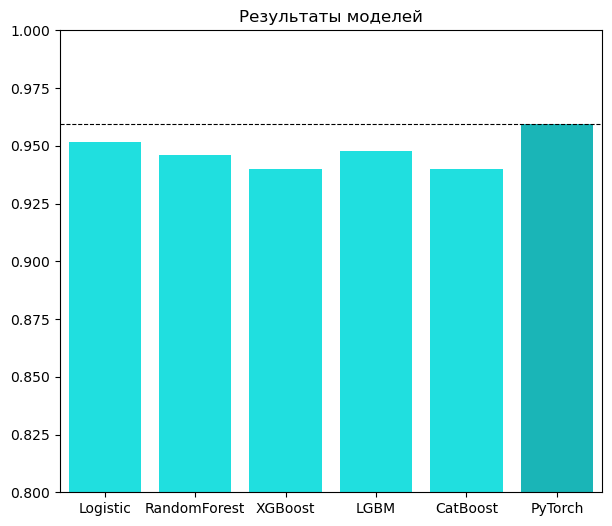

In [53]:
accuracy_list2 = [accuracy_log, accuracy_rf, accuracy_xgb, accuracy_lgbm, accuracy_catb, accuracy_pytorch]
fig, ax=plt.subplots(figsize=(7,6))
cols = ["aqua" if i < (max(accuracy_list2)) else "darkturquoise" for i in accuracy_list2]
sns.barplot(x=np.arange(0,6), y=accuracy_list2, ax=ax, palette=cols)
plt.ylim(0.8, 1)
plt.title("Результаты моделей")
plt.axhline(accuracy_pytorch, lw=0.8, ls="--", color="k")
ax.set_xticklabels(["Logistic", "RandomForest", "XGBoost", "LGBM", "CatBoost", "PyTorch"])
print(accuracy_list2)
plt.show()

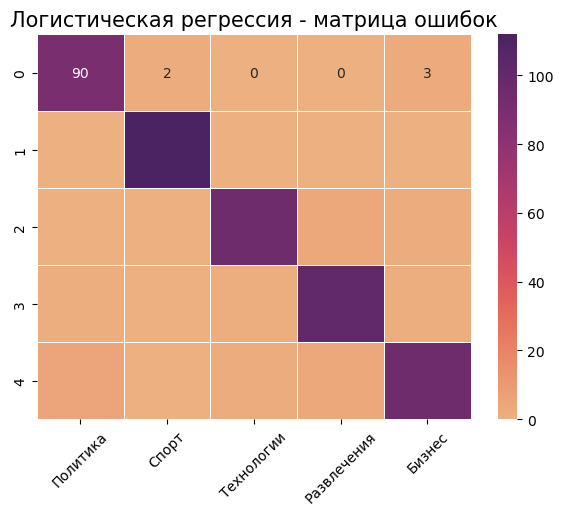

In [54]:
fig, ax=plt.subplots(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, linewidths=0.4, cmap="flare", fmt='.3g', ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], rotation=45)
ax.set_title("Логистическая регрессия - матрица ошибок", fontsize=15)
plt.show()

In [55]:
print(f"############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############\n\n {classification_report(y_test, y_pred_log)}")

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############

               precision    recall  f1-score   support

           0       0.94      0.95      0.94        95
           1       0.98      1.00      0.99       112
           2       0.97      0.94      0.95       101
           3       0.93      0.97      0.95       104
           4       0.94      0.90      0.92       106

    accuracy                           0.95       518
   macro avg       0.95      0.95      0.95       518
weighted avg       0.95      0.95      0.95       518



## Самое важное для LGBM

In [56]:
df_feature_importance = pd.DataFrame(lgbm.feature_importances_, columns=["feature_importance"])
df_feature_importance["features"] = df_nlp.columns[1:]
df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
df_feature_importance.head()

,feature_importance,features
0,339,text_length
1,338,caps_count
2,295,stopwords_count
3,248,word_count
4,240,игра


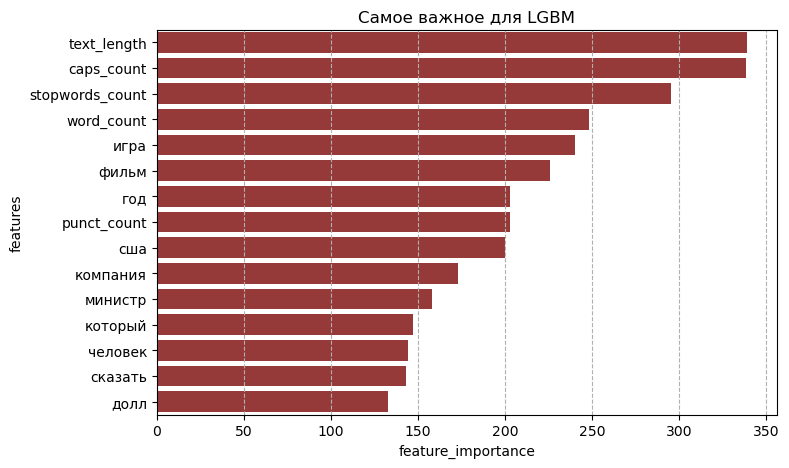

In [57]:
plt.figure(figsize=(8,5))
sns.barplot(x=df_feature_importance.feature_importance[:15], y=df_feature_importance.features[:15], color="brown")
plt.title("Самое важное для LGBM")
plt.grid(axis="x", ls="--")
plt.show()

### Очистка текста (3 метод - стемминг)

In [58]:
df = pd.read_csv("data_kaggle_ru.csv")
df = df[["text", "label"]]
df = df.rename(columns={'text':'Text','label':'Label'})
df = df.drop_duplicates()

def clean_text3(text):
    text = re.sub('\n', " ", text)
    text = re.sub(r'[^а-яА-Я]', " ", text)
    text = re.sub(r'\s+', " ", text)
    text = text.lower()
    text = text.split()
    text = [j for j in text if len(j) > 1]    
    text = [i for i in text if not i in set(stopwords.words("russian"))]
    stemmer = snowballstemmer.stemmer('russian')
    text = [stemmer.stemWord(word) for word in text]    
    text = " ".join(text)
    return text

df["cleaned_text"] = df["Text"].apply(clean_text3)

In [59]:
df.head()

,Text,Label,cleaned_text
0,Бюджет для создания условий для выборов\n \n Г...,0,бюджет создан услов выбор гордон браун постара...
1,Армейские вожди в составе полков\n \n Ожидаетс...,0,армейск вожд состав полк ожида воен вожд встре...
2,Говард отрицает разбивку на удостоверения личн...,0,говард отрица разбивк удостоверен личност майк...
3,Наблюдатели за выборами в Соединенном Королевс...,0,наблюдател выбор соединен королевств министр п...
4,Килрой назвал выборное место\n \n Бывший орган...,0,килр назва выборн мест бывш организатор шо роб...


## Статистика по тексту

In [60]:
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

df["text_length"] = df["cleaned_text"].apply(lambda x: len(str(x)))

df["stopwords_count"] = df["Text"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("russian"))]))

df["punct_count"] = df["Text"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["caps_count"] = df["Text"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df.head()

,Text,Label,cleaned_text,word_count,text_length,stopwords_count,punct_count,caps_count
0,Бюджет для создания условий для выборов\n \n Г...,0,бюджет создан услов выбор гордон браун постара...,343,2435,108,86,57
1,Армейские вожди в составе полков\n \n Ожидаетс...,0,армейск вожд состав полк ожида воен вожд встре...,288,2067,106,83,46
2,Говард отрицает разбивку на удостоверения личн...,0,говард отрица разбивк удостоверен личност майк...,331,2326,123,109,63
3,Наблюдатели за выборами в Соединенном Королевс...,0,наблюдател выбор соединен королевств министр п...,340,2505,131,81,56
4,Килрой назвал выборное место\n \n Бывший орган...,0,килр назва выборн мест бывш организатор шо роб...,274,1848,106,96,109


In [61]:
grouped_text = df.groupby("Label").agg({"word_count": "mean",
                                        "text_length": "mean",
                                        "stopwords_count": "mean",
                                        "punct_count": "mean",
                                        "caps_count": "mean"})
grouped_text = grouped_text.reset_index(drop=True)
grouped_text

,word_count,text_length,stopwords_count,punct_count,caps_count
0,279.034739,1953.200993,111.652605,88.933002,60.119107
1,182.976238,1180.607921,82.200000,68.780198,63.982178
2,297.939130,2074.637681,113.455072,98.449275,72.304348
3,191.439024,1253.964770,72.604336,66.910569,67.260163
4,209.658052,1455.335984,72.391650,68.817097,55.952286


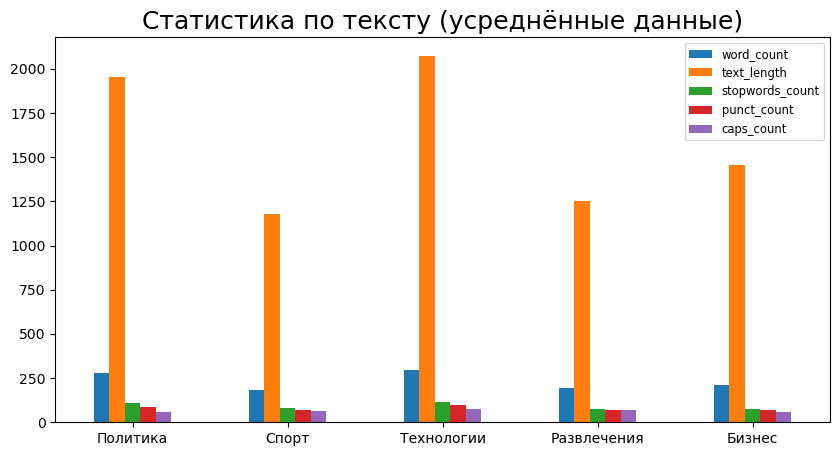

In [62]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_text.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])
ax.set_title("Статистика по тексту (усреднённые данные)", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

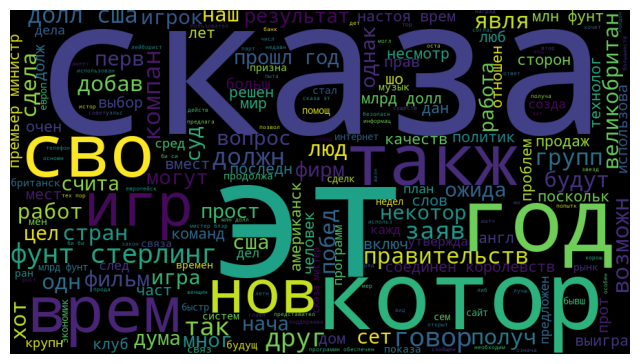

In [63]:
all_cleaned_text = " ".join(df["cleaned_text"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_text)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

## CountVectorizer

In [64]:
count_vec = CountVectorizer(max_features=5000)
count_array = count_vec.fit_transform(df["cleaned_text"]).toarray()
df_count_vec = pd.DataFrame(count_array, columns=count_vec.get_feature_names_out())
df_count_vec = df_count_vec.reset_index(drop=True)
df_count_vec.head()

,аббас,аборт,абсолютн,авар,август,авиакомпан,авиатор,авиац,авив,австр,...,японск,ярд,ярк,ярлык,ярмарк,ясн,ях,ячв,ячейк,ящик
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [65]:
df1 = df.iloc[:, [1,3,4,5,6,7]]
df1 = df1.reset_index(drop=True)
df1.head()

,Label,word_count,text_length,stopwords_count,punct_count,caps_count
0,0,343,2435,108,86,57
1,0,288,2067,106,83,46
2,0,331,2326,123,109,63
3,0,340,2505,131,81,56
4,0,274,1848,106,96,109


In [66]:
df_nlp = pd.concat([df1, df_count_vec], axis=1)
df_nlp.head()

,Label,word_count,text_length,stopwords_count,punct_count,caps_count,аббас,аборт,абсолютн,авар,...,японск,ярд,ярк,ярлык,ярмарк,ясн,ях,ячв,ячейк,ящик
0,0,343,2435,108,86,57,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,288,2067,106,83,46,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,331,2326,123,109,63,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,340,2505,131,81,56,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,274,1848,106,96,109,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


## RandomUnderSampler

In [67]:
y = df_nlp["Label"]
X = df_nlp.drop("Label", axis=1)

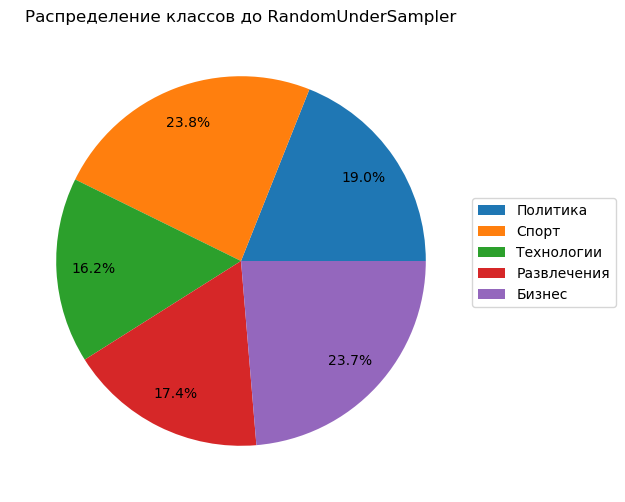

In [68]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов до RandomUnderSampler")
plt.show()

In [69]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

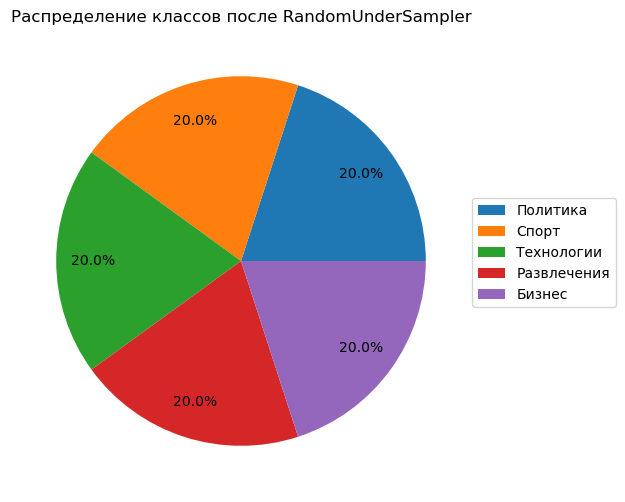

In [70]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов после RandomUnderSampler")
plt.show()

In [71]:
print(X.shape)
print(y.shape)

(1725, 5005)
(1725,)


### train/test - разделение

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Стандартизация

In [73]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Модели

In [74]:
#######  Logistic Regression  #######
log = LogisticRegression().fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

#######  RandomForest  #######
rf = RandomForestClassifier().fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#######  XGB Classifier  #######
xgb = XGBClassifier().fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

#######  LGBM Classifier  #######
lgbm = LGBMClassifier().fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

#######  CatBoost Classifier  #######
catb = CatBoostClassifier(verbose=False).fit(X_train_scaled, y_train)
y_pred_catb = catb.predict(X_test_scaled)

#######  PyTorch  #######
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_size = X_train_tensor.shape[1]
hidden_size = 64
num_classes = len(np.unique(y_train))
learning_rate = 0.001
num_epochs = 50

model = NeuralNetwork(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
y_pred_pytorch = predicted.numpy()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009480 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11742
[LightGBM] [Info] Number of data points in the train set: 1207, number of used features: 2051
[LightGBM] [Info] Start training from score -1.574432
[LightGBM] [Info] Start training from score -1.644855
[LightGBM] [Info] Start training from score -1.598725
[LightGBM] [Info] Start training from score -1.611096
[LightGBM] [Info] Start training from score -1.619430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


### Расчёт accuracy

In [75]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catb = accuracy_score(y_test, y_pred_catb)
accuracy_pytorch = accuracy_score(y_test, y_pred_pytorch)

## Результаты моделей

[0.9575289575289575, 0.9517374517374517, 0.9362934362934363, 0.9459459459459459, 0.9517374517374517, 0.9633204633204633]


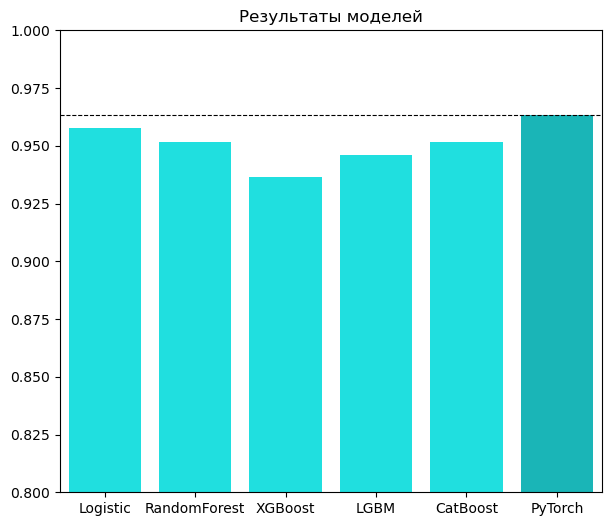

In [76]:
accuracy_list3 = [accuracy_log, accuracy_rf, accuracy_xgb, accuracy_lgbm, accuracy_catb, accuracy_pytorch]
fig, ax=plt.subplots(figsize=(7,6))
cols = ["aqua" if i < (max(accuracy_list3)) else "darkturquoise" for i in accuracy_list3]
sns.barplot(x=np.arange(0,6), y=accuracy_list3, ax=ax, palette=cols)
plt.ylim(0.8, 1)
plt.title("Результаты моделей")
plt.axhline(accuracy_pytorch, lw=0.8, ls="--", color="k")
ax.set_xticklabels(["Logistic", "RandomForest", "XGBoost", "LGBM", "CatBoost", "PyTorch"])
print(accuracy_list3)
plt.show()

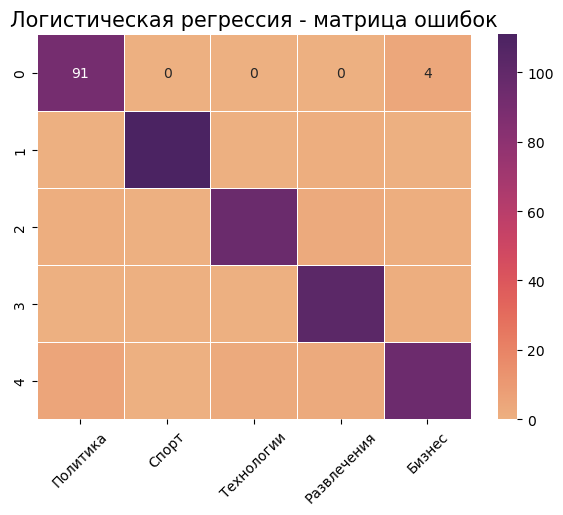

In [77]:
fig, ax=plt.subplots(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, linewidths=0.4, cmap="flare", fmt='.3g', ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], rotation=45)
ax.set_title("Логистическая регрессия - матрица ошибок", fontsize=15)
plt.show()

In [78]:
print(f"############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############\n\n {classification_report(y_test, y_pred_log)}")

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############

               precision    recall  f1-score   support

           0       0.94      0.96      0.95        95
           1       1.00      0.99      1.00       112
           2       0.97      0.95      0.96       101
           3       0.94      0.99      0.96       104
           4       0.94      0.90      0.92       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



## Самое важное для LGBM

In [79]:
df_feature_importance = pd.DataFrame(lgbm.feature_importances_, columns=["feature_importance"])
df_feature_importance["features"] = df_nlp.columns[1:]
df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
df_feature_importance.head()

,feature_importance,features
0,350,text_length
1,348,caps_count
2,234,stopwords_count
3,230,word_count
4,218,год


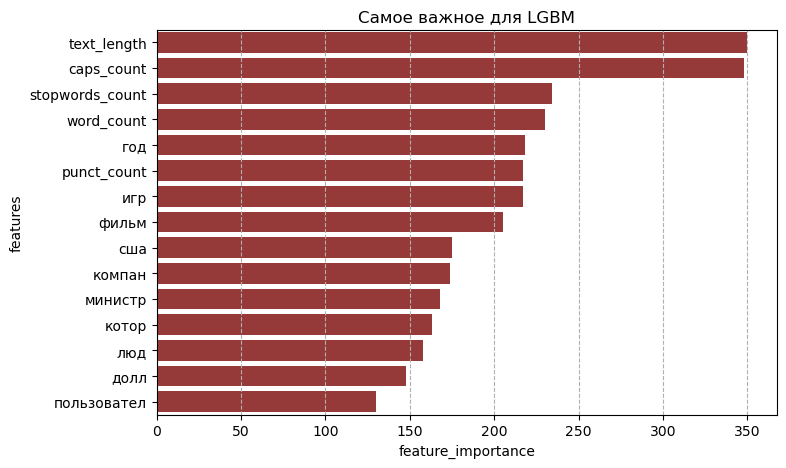

In [80]:
plt.figure(figsize=(8,5))
sns.barplot(x=df_feature_importance.feature_importance[:15], y=df_feature_importance.features[:15], color="brown")
plt.title("Самое важное для LGBM")
plt.grid(axis="x", ls="--")
plt.show()

### Очистка текста (4 метод - би-граммы)

In [81]:
df = pd.read_csv("data_kaggle_ru.csv")
df = df[["text", "label"]]
df = df.rename(columns={'text':'Text','label':'Label'})
df = df.drop_duplicates()

def clean_text4(text):
    text = re.sub('\n', " ", text)
    text = re.sub(r'[^а-яА-Я]', " ", text)
    text = re.sub(r'\s+', " ", text)
    text = text.lower()
    text = text.split()
    text = [j for j in text if len(j) > 1]    
    text = [i for i in text if not i in set(stopwords.words("russian"))]
    n_grams = [' '.join(gram) for gram in ngrams(text, 2)]
    n_grams = " ".join(n_grams)
    return n_grams

df["cleaned_text"] = df["Text"].apply(clean_text4)

In [82]:
df.head()

,Text,Label,cleaned_text
0,Бюджет для создания условий для выборов\n \n Г...,0,бюджет создания создания условий условий выбор...
1,Армейские вожди в составе полков\n \n Ожидаетс...,0,армейские вожди вожди составе составе полков п...
2,Говард отрицает разбивку на удостоверения личн...,0,говард отрицает отрицает разбивку разбивку удо...
3,Наблюдатели за выборами в Соединенном Королевс...,0,наблюдатели выборами выборами соединенном соед...
4,Килрой назвал выборное место\n \n Бывший орган...,0,килрой назвал назвал выборное выборное место м...


## Статистика по тексту

In [83]:
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

df["text_length"] = df["cleaned_text"].apply(lambda x: len(str(x)))

df["stopwords_count"] = df["Text"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("russian"))]))

df["punct_count"] = df["Text"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["caps_count"] = df["Text"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df.head()

,Text,Label,cleaned_text,word_count,text_length,stopwords_count,punct_count,caps_count
0,Бюджет для создания условий для выборов\n \n Г...,0,бюджет создания создания условий условий выбор...,684,5956,108,86,57
1,Армейские вожди в составе полков\n \n Ожидаетс...,0,армейские вожди вожди составе составе полков п...,574,5100,106,83,46
2,Говард отрицает разбивку на удостоверения личн...,0,говард отрицает отрицает разбивку разбивку удо...,660,5659,123,109,63
3,Наблюдатели за выборами в Соединенном Королевс...,0,наблюдатели выборами выборами соединенном соед...,678,6158,131,81,56
4,Килрой назвал выборное место\n \n Бывший орган...,0,килрой назвал назвал выборное выборное место м...,546,4536,106,96,109


In [84]:
grouped_text = df.groupby("Label").agg({"word_count": "mean",
                                        "text_length": "mean",
                                        "stopwords_count": "mean",
                                        "punct_count": "mean",
                                        "caps_count": "mean"})
grouped_text = grouped_text.reset_index(drop=True)
grouped_text

,word_count,text_length,stopwords_count,punct_count,caps_count
0,556.069479,4793.143921,111.652605,88.933002,60.119107
1,363.952475,2880.968317,82.200000,68.780198,63.982178
2,593.878261,5138.081159,113.455072,98.449275,72.304348
3,380.878049,3061.747967,72.604336,66.910569,67.260163
4,417.316103,3574.147117,72.391650,68.817097,55.952286


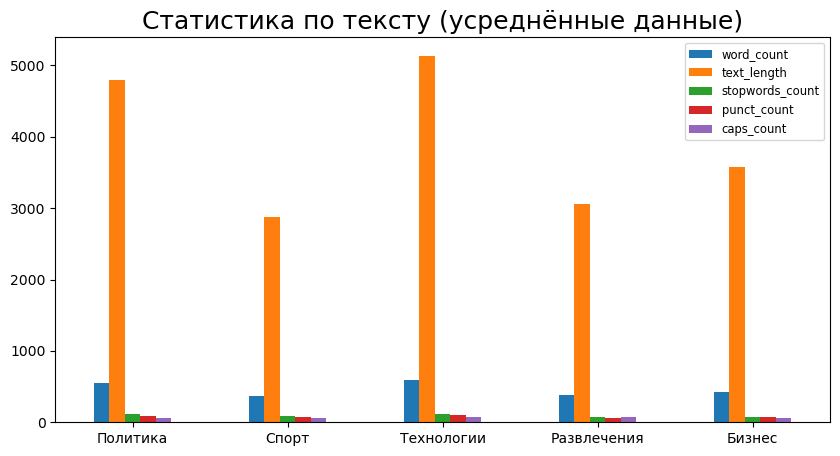

In [85]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_text.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])
ax.set_title("Статистика по тексту (усреднённые данные)", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

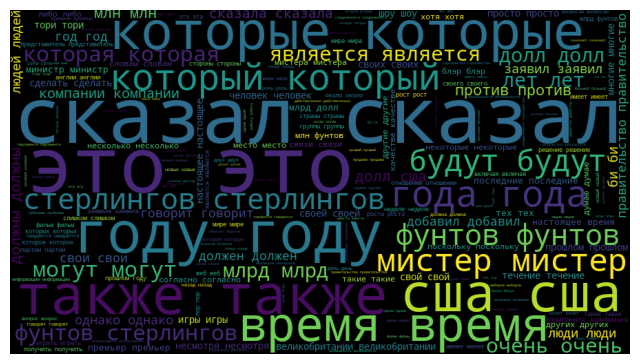

In [86]:
all_cleaned_text = " ".join(df["cleaned_text"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_text)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

## CountVectorizer

In [87]:
count_vec = CountVectorizer(max_features=5000)
count_array = count_vec.fit_transform(df["cleaned_text"]).toarray()
df_count_vec = pd.DataFrame(count_array, columns=count_vec.get_feature_names_out())
df_count_vec = df_count_vec.reset_index(drop=True)
df_count_vec.head()

,абсолютно,аварии,августа,августе,авиакомпании,авиакомпаний,авиакомпания,авиатор,австралии,австралийский,...,ян,январе,января,янг,японии,япония,японская,японский,ярдов,ясно
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


In [88]:
df1 = df.iloc[:, [1,3,4,5,6,7]]
df1 = df1.reset_index(drop=True)
df1.head()

,Label,word_count,text_length,stopwords_count,punct_count,caps_count
0,0,684,5956,108,86,57
1,0,574,5100,106,83,46
2,0,660,5659,123,109,63
3,0,678,6158,131,81,56
4,0,546,4536,106,96,109


In [89]:
df_nlp = pd.concat([df1, df_count_vec], axis=1)
df_nlp.head()

,Label,word_count,text_length,stopwords_count,punct_count,caps_count,абсолютно,аварии,августа,августе,...,ян,январе,января,янг,японии,япония,японская,японский,ярдов,ясно
0,0,684,5956,108,86,57,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,574,5100,106,83,46,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,660,5659,123,109,63,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,678,6158,131,81,56,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,546,4536,106,96,109,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2


## RandomUnderSampler

In [90]:
y = df_nlp["Label"]
X = df_nlp.drop("Label", axis=1)

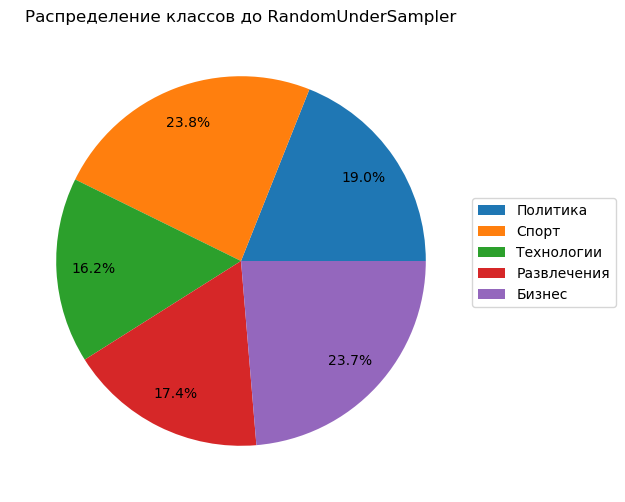

In [91]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов до RandomUnderSampler")
plt.show()

In [92]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

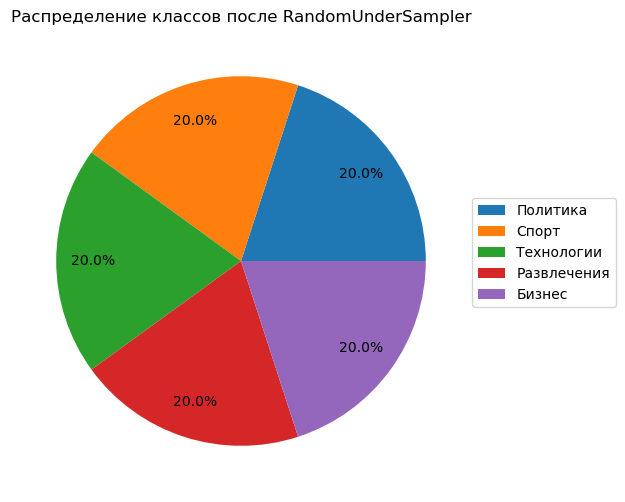

In [93]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов после RandomUnderSampler")
plt.show()

In [94]:
print(X.shape)
print(y.shape)

(1725, 5005)
(1725,)


### train/test - разделение

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Стандартизация

In [96]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Модели

In [97]:
#######  Logistic Regression  #######
log = LogisticRegression().fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

#######  RandomForest  #######
rf = RandomForestClassifier().fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#######  XGB Classifier  #######
xgb = XGBClassifier().fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

#######  LGBM Classifier  #######
lgbm = LGBMClassifier().fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

#######  CatBoost Classifier  #######
catb = CatBoostClassifier(verbose=False).fit(X_train_scaled, y_train)
y_pred_catb = catb.predict(X_test_scaled)

#######  PyTorch  #######
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_size = X_train_tensor.shape[1]
hidden_size = 64
num_classes = len(np.unique(y_train))
learning_rate = 0.001
num_epochs = 50

model = NeuralNetwork(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
y_pred_pytorch = predicted.numpy()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10433
[LightGBM] [Info] Number of data points in the train set: 1207, number of used features: 2001
[LightGBM] [Info] Start training from score -1.574432
[LightGBM] [Info] Start training from score -1.644855
[LightGBM] [Info] Start training from score -1.598725
[LightGBM] [Info] Start training from score -1.611096
[LightGBM] [Info] Start training from score -1.619430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


### Расчёт accuracy

In [98]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catb = accuracy_score(y_test, y_pred_catb)
accuracy_pytorch = accuracy_score(y_test, y_pred_pytorch)

## Результаты моделей

[0.9633204633204633, 0.9343629343629344, 0.9227799227799228, 0.9459459459459459, 0.9478764478764479, 0.9652509652509652]


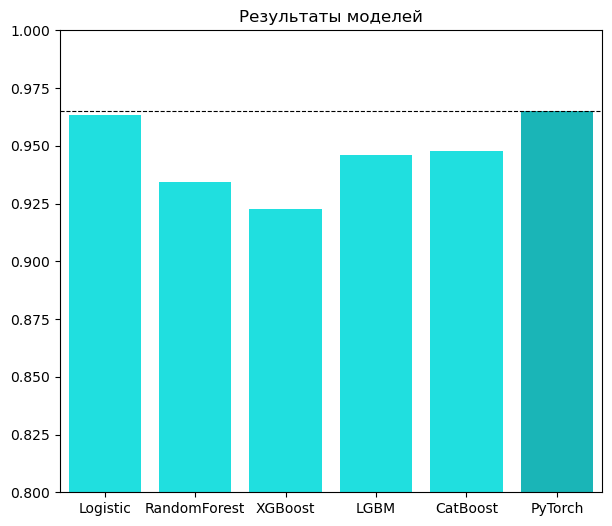

In [99]:
accuracy_list4 = [accuracy_log, accuracy_rf, accuracy_xgb, accuracy_lgbm, accuracy_catb, accuracy_pytorch]
fig, ax=plt.subplots(figsize=(7,6))
cols = ["aqua" if i < (max(accuracy_list4)) else "darkturquoise" for i in accuracy_list4]
sns.barplot(x=np.arange(0,6), y=accuracy_list4, ax=ax, palette=cols)
plt.ylim(0.8, 1)
plt.title("Результаты моделей")
plt.axhline(accuracy_pytorch, lw=0.8, ls="--", color="k")
ax.set_xticklabels(["Logistic", "RandomForest", "XGBoost", "LGBM", "CatBoost", "PyTorch"])
print(accuracy_list4)
plt.show()

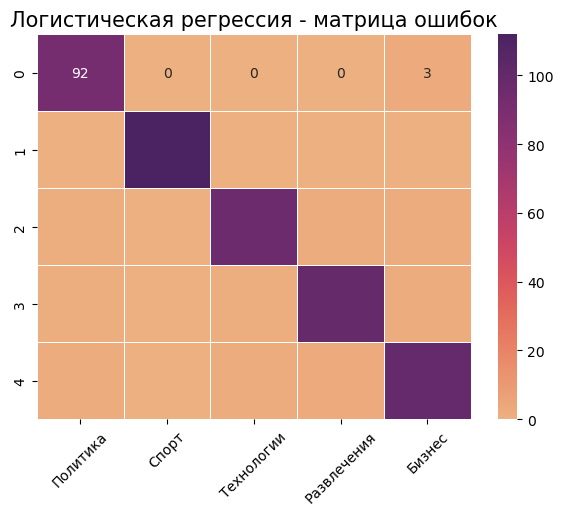

In [100]:
fig, ax=plt.subplots(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, linewidths=0.4, cmap="flare", fmt='.3g', ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], rotation=45)
ax.set_title("Логистическая регрессия - матрица ошибок", fontsize=15)
plt.show()

In [101]:
print(f"############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############\n\n {classification_report(y_test, y_pred_log)}")

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############

               precision    recall  f1-score   support

           0       0.96      0.97      0.96        95
           1       1.00      1.00      1.00       112
           2       0.97      0.95      0.96       101
           3       0.95      0.96      0.96       104
           4       0.93      0.93      0.93       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



## Самое важное для LGBM

In [102]:
df_feature_importance = pd.DataFrame(lgbm.feature_importances_, columns=["feature_importance"])
df_feature_importance["features"] = df_nlp.columns[1:]
df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
df_feature_importance.head()

,feature_importance,features
0,551,text_length
1,522,caps_count
2,466,stopwords_count
3,345,punct_count
4,255,word_count


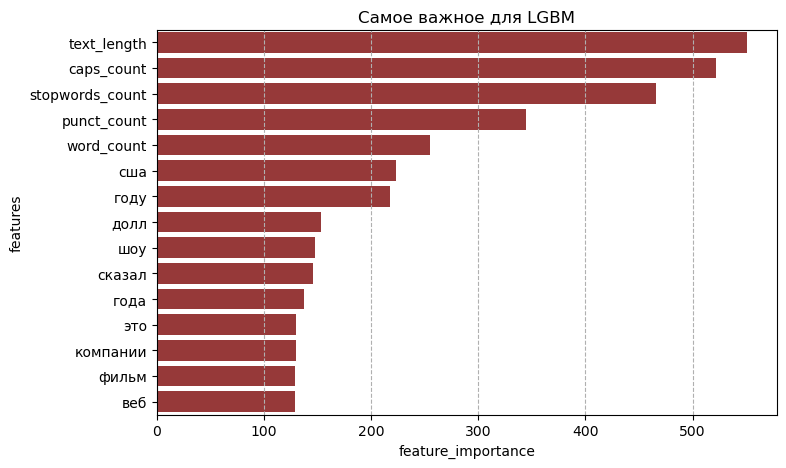

In [103]:
plt.figure(figsize=(8,5))
sns.barplot(x=df_feature_importance.feature_importance[:15], y=df_feature_importance.features[:15], color="brown")
plt.title("Самое важное для LGBM")
plt.grid(axis="x", ls="--")
plt.show()

### Очистка текста (5 метод - 3-граммы)

In [104]:
df = pd.read_csv("data_kaggle_ru.csv")
df = df[["text", "label"]]
df = df.rename(columns={'text':'Text','label':'Label'})
df = df.drop_duplicates()

def clean_text5(text):
    text = re.sub('\n', " ", text)
    text = re.sub(r'[^а-яА-Я]', " ", text)
    text = re.sub(r'\s+', " ", text)
    text = text.lower()
    text = text.split()
    text = [j for j in text if len(j) > 1]    
    text = [i for i in text if not i in set(stopwords.words("russian"))]
    n_grams = [' '.join(gram) for gram in ngrams(text, 3)]
    n_grams = " ".join(n_grams)
    return n_grams

df["cleaned_text"] = df["Text"].apply(clean_text5)

In [105]:
df.head()

,Text,Label,cleaned_text
0,Бюджет для создания условий для выборов\n \n Г...,0,бюджет создания условий создания условий выбор...
1,Армейские вожди в составе полков\n \n Ожидаетс...,0,армейские вожди составе вожди составе полков с...
2,Говард отрицает разбивку на удостоверения личн...,0,говард отрицает разбивку отрицает разбивку удо...
3,Наблюдатели за выборами в Соединенном Королевс...,0,наблюдатели выборами соединенном выборами соед...
4,Килрой назвал выборное место\n \n Бывший орган...,0,килрой назвал выборное назвал выборное место в...


## Статистика по тексту

In [106]:
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

df["text_length"] = df["cleaned_text"].apply(lambda x: len(str(x)))

df["stopwords_count"] = df["Text"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("russian"))]))

df["punct_count"] = df["Text"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["caps_count"] = df["Text"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df.head()

,Text,Label,cleaned_text,word_count,text_length,stopwords_count,punct_count,caps_count
0,Бюджет для создания условий для выборов\n \n Г...,0,бюджет создания условий создания условий выбор...,1023,8909,108,86,57
1,Армейские вожди в составе полков\n \n Ожидаетс...,0,армейские вожди составе вожди составе полков с...,858,7620,106,83,46
2,Говард отрицает разбивку на удостоверения личн...,0,говард отрицает разбивку отрицает разбивку удо...,987,8460,123,109,63
3,Наблюдатели за выборами в Соединенном Королевс...,0,наблюдатели выборами соединенном выборами соед...,1014,9208,131,81,56
4,Килрой назвал выборное место\n \n Бывший орган...,0,килрой назвал выборное назвал выборное место в...,816,6785,106,96,109


In [107]:
grouped_text = df.groupby("Label").agg({"word_count": "mean",
                                        "text_length": "mean",
                                        "stopwords_count": "mean",
                                        "punct_count": "mean",
                                        "caps_count": "mean"})
grouped_text = grouped_text.reset_index(drop=True)
grouped_text

,word_count,text_length,stopwords_count,punct_count,caps_count
0,831.104218,7163.761787,111.652605,88.933002,60.119107
1,542.928713,4297.566337,82.200000,68.780198,63.982178
2,887.817391,7681.678261,113.455072,98.449275,72.304348
3,568.317073,4569.132791,72.604336,66.910569,67.260163
4,622.974155,5336.073559,72.391650,68.817097,55.952286


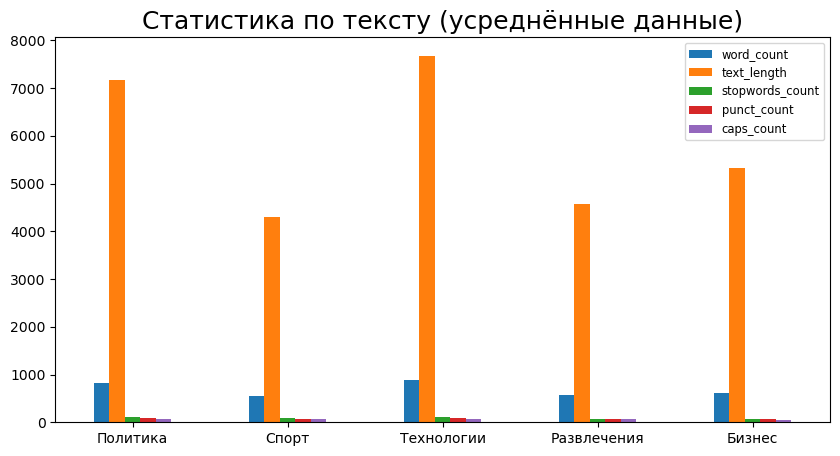

In [108]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_text.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])
ax.set_title("Статистика по тексту (усреднённые данные)", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

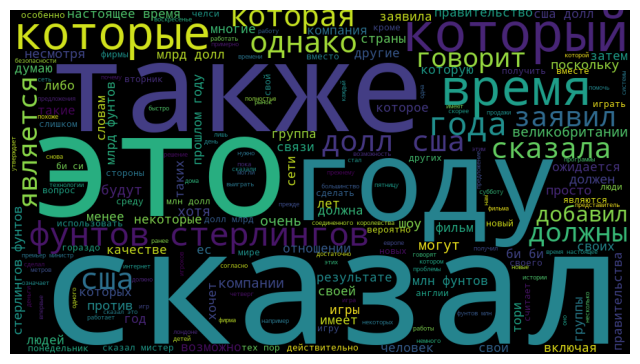

In [109]:
all_cleaned_text = " ".join(df["cleaned_text"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_text)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

## CountVectorizer

In [110]:
count_vec = CountVectorizer(max_features=5000)
count_array = count_vec.fit_transform(df["cleaned_text"]).toarray()
df_count_vec = pd.DataFrame(count_array, columns=count_vec.get_feature_names_out())
df_count_vec = df_count_vec.reset_index(drop=True)
df_count_vec.head()

,абсолютно,аварии,августа,августе,авиакомпании,авиакомпаний,авиакомпания,авиатор,австралии,австралийский,...,ян,январе,января,янг,японии,япония,японская,японский,ярдов,ясно
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


In [111]:
df1 = df.iloc[:, [1,3,4,5,6,7]]
df1 = df1.reset_index(drop=True)
df1.head()

,Label,word_count,text_length,stopwords_count,punct_count,caps_count
0,0,1023,8909,108,86,57
1,0,858,7620,106,83,46
2,0,987,8460,123,109,63
3,0,1014,9208,131,81,56
4,0,816,6785,106,96,109


In [112]:
df_nlp = pd.concat([df1, df_count_vec], axis=1)
df_nlp.head()

,Label,word_count,text_length,stopwords_count,punct_count,caps_count,абсолютно,аварии,августа,августе,...,ян,январе,января,янг,японии,япония,японская,японский,ярдов,ясно
0,0,1023,8909,108,86,57,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,858,7620,106,83,46,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,987,8460,123,109,63,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1014,9208,131,81,56,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,816,6785,106,96,109,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3


## RandomUnderSampler

In [113]:
y = df_nlp["Label"]
X = df_nlp.drop("Label", axis=1)

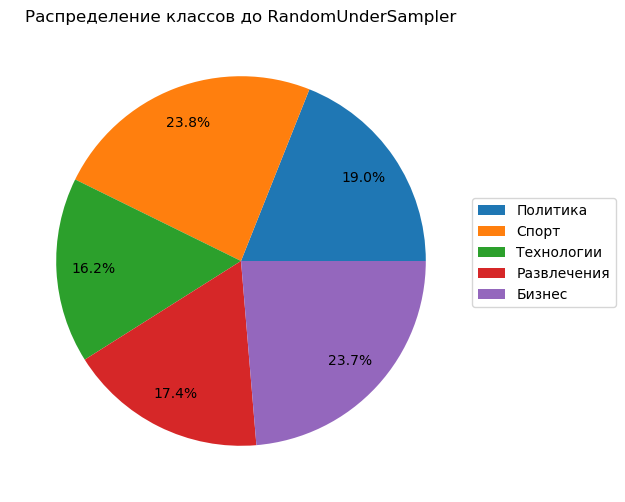

In [114]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов до RandomUnderSampler")
plt.show()

In [115]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

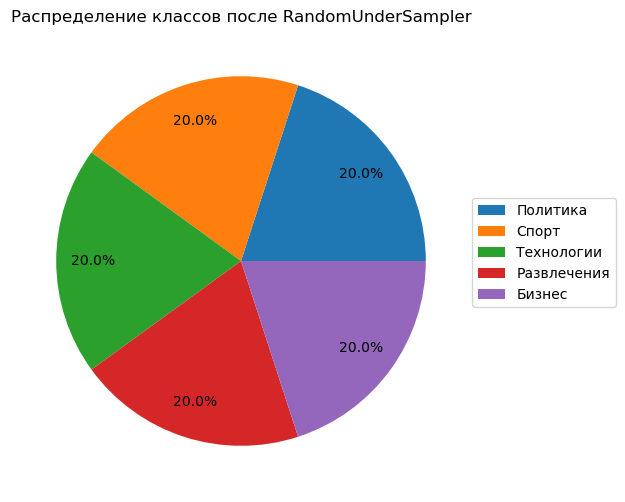

In [116]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов после RandomUnderSampler")
plt.show()

In [117]:
print(X.shape)
print(y.shape)

(1725, 5005)
(1725,)


### train/test - разделение

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Стандартизация

In [119]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Модели

In [120]:
#######  Logistic Regression  #######
log = LogisticRegression().fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

#######  RandomForest  #######
rf = RandomForestClassifier().fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#######  XGB Classifier  #######
xgb = XGBClassifier().fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

#######  LGBM Classifier  #######
lgbm = LGBMClassifier().fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

#######  CatBoost Classifier  #######
catb = CatBoostClassifier(verbose=False).fit(X_train_scaled, y_train)
y_pred_catb = catb.predict(X_test_scaled)

#######  PyTorch  #######
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_size = X_train_tensor.shape[1]
hidden_size = 64
num_classes = len(np.unique(y_train))
learning_rate = 0.001
num_epochs = 50

model = NeuralNetwork(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
y_pred_pytorch = predicted.numpy()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10523
[LightGBM] [Info] Number of data points in the train set: 1207, number of used features: 2001
[LightGBM] [Info] Start training from score -1.574432
[LightGBM] [Info] Start training from score -1.644855
[LightGBM] [Info] Start training from score -1.598725
[LightGBM] [Info] Start training from score -1.611096
[LightGBM] [Info] Start training from score -1.619430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


### Расчёт accuracy

In [121]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catb = accuracy_score(y_test, y_pred_catb)
accuracy_pytorch = accuracy_score(y_test, y_pred_pytorch)

## Результаты моделей

[0.9613899613899614, 0.9343629343629344, 0.9285714285714286, 0.944015444015444, 0.9420849420849421, 0.9652509652509652]


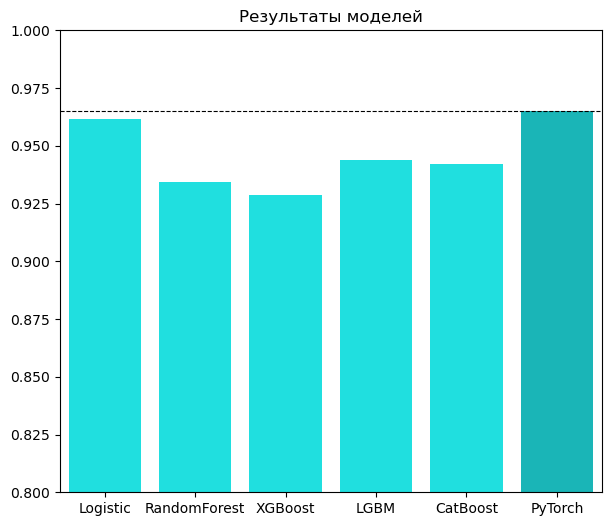

In [122]:
accuracy_list5 = [accuracy_log, accuracy_rf, accuracy_xgb, accuracy_lgbm, accuracy_catb, accuracy_pytorch]
fig, ax=plt.subplots(figsize=(7,6))
cols = ["aqua" if i < (max(accuracy_list5)) else "darkturquoise" for i in accuracy_list5]
sns.barplot(x=np.arange(0,6), y=accuracy_list5, ax=ax, palette=cols)
plt.ylim(0.8, 1)
plt.title("Результаты моделей")
plt.axhline(accuracy_pytorch, lw=0.8, ls="--", color="k")
ax.set_xticklabels(["Logistic", "RandomForest", "XGBoost", "LGBM", "CatBoost", "PyTorch"])
print(accuracy_list5)
plt.show()

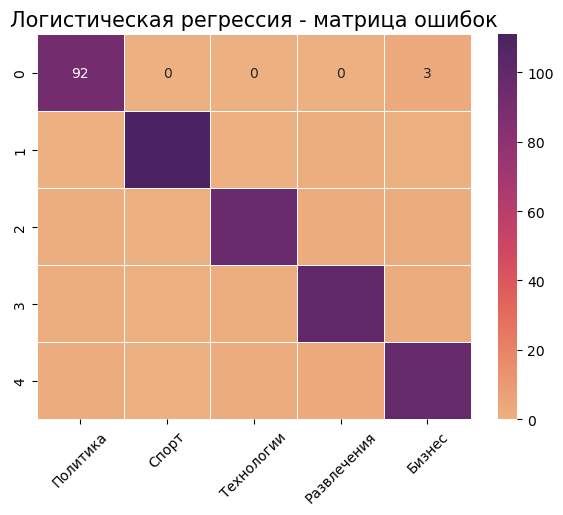

In [123]:
fig, ax=plt.subplots(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, linewidths=0.4, cmap="flare", fmt='.3g', ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], rotation=45)
ax.set_title("Логистическая регрессия - матрица ошибок", fontsize=15)
plt.show()

In [124]:
print(f"############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############\n\n {classification_report(y_test, y_pred_log)}")

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############

               precision    recall  f1-score   support

           0       0.96      0.97      0.96        95
           1       1.00      0.99      1.00       112
           2       0.97      0.95      0.96       101
           3       0.94      0.96      0.95       104
           4       0.93      0.93      0.93       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



## Самое важное для LGBM

In [125]:
df_feature_importance = pd.DataFrame(lgbm.feature_importances_, columns=["feature_importance"])
df_feature_importance["features"] = df_nlp.columns[1:]
df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
df_feature_importance.head()

,feature_importance,features
0,591,caps_count
1,508,text_length
2,457,stopwords_count
3,327,punct_count
4,231,word_count


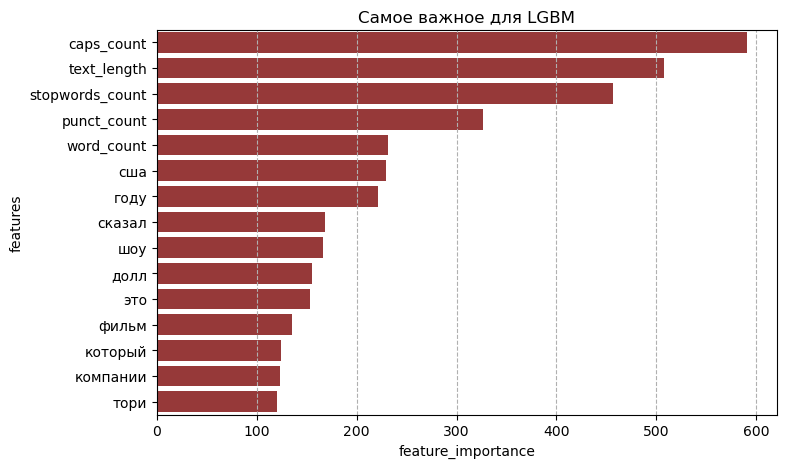

In [126]:
plt.figure(figsize=(8,5))
sns.barplot(x=df_feature_importance.feature_importance[:15], y=df_feature_importance.features[:15], color="brown")
plt.title("Самое важное для LGBM")
plt.grid(axis="x", ls="--")
plt.show()

### Очистка текста (6 метод - 4-граммы)

In [127]:
df = pd.read_csv("data_kaggle_ru.csv")
df = df[["text", "label"]]
df = df.rename(columns={'text':'Text','label':'Label'})
df = df.drop_duplicates()

def clean_text6(text):
    text = re.sub('\n', " ", text)
    text = re.sub(r'[^а-яА-Я]', " ", text)
    text = re.sub(r'\s+', " ", text)
    text = text.lower()
    text = text.split()
    text = [j for j in text if len(j) > 1]    
    text = [i for i in text if not i in set(stopwords.words("russian"))]
    n_grams = [' '.join(gram) for gram in ngrams(text, 4)]
    n_grams = " ".join(n_grams)
    return n_grams

df["cleaned_text"] = df["Text"].apply(clean_text6)

In [128]:
df.head()

,Text,Label,cleaned_text
0,Бюджет для создания условий для выборов\n \n Г...,0,бюджет создания условий выборов создания услов...
1,Армейские вожди в составе полков\n \n Ожидаетс...,0,армейские вожди составе полков вожди составе п...
2,Говард отрицает разбивку на удостоверения личн...,0,говард отрицает разбивку удостоверения отрицае...
3,Наблюдатели за выборами в Соединенном Королевс...,0,наблюдатели выборами соединенном королевстве в...
4,Килрой назвал выборное место\n \n Бывший орган...,0,килрой назвал выборное место назвал выборное м...


## Статистика по тексту

In [129]:
df["word_count"] = df["cleaned_text"].apply(lambda x: len(x.split()))

df["text_length"] = df["cleaned_text"].apply(lambda x: len(str(x)))

df["stopwords_count"] = df["Text"].apply(lambda x: len([i for i in x.split() if i in set(stopwords.words("russian"))]))

df["punct_count"] = df["Text"].apply(lambda x: len([i for i in x if i in string.punctuation]))

df["caps_count"] = df["Text"].apply(lambda x: len([i for i in str(x) if i.isupper()]))

df.head()

,Text,Label,cleaned_text,word_count,text_length,stopwords_count,punct_count,caps_count
0,Бюджет для создания условий для выборов\n \n Г...,0,бюджет создания условий выборов создания услов...,1360,11848,108,86,57
1,Армейские вожди в составе полков\n \n Ожидаетс...,0,армейские вожди составе полков вожди составе п...,1140,10126,106,83,46
2,Говард отрицает разбивку на удостоверения личн...,0,говард отрицает разбивку удостоверения отрицае...,1312,11237,123,109,63
3,Наблюдатели за выборами в Соединенном Королевс...,0,наблюдатели выборами соединенном королевстве в...,1348,12237,131,81,56
4,Килрой назвал выборное место\n \n Бывший орган...,0,килрой назвал выборное место назвал выборное м...,1084,9017,106,96,109


In [130]:
grouped_text = df.groupby("Label").agg({"word_count": "mean",
                                        "text_length": "mean",
                                        "stopwords_count": "mean",
                                        "punct_count": "mean",
                                        "caps_count": "mean"})
grouped_text = grouped_text.reset_index(drop=True)
grouped_text

,word_count,text_length,stopwords_count,punct_count,caps_count
0,1104.138958,9516.662531,111.652605,88.933002,60.119107
1,719.904950,5697.936634,82.200000,68.780198,63.982178
2,1179.756522,10207.910145,113.455072,98.449275,72.304348
3,753.756098,6059.978320,72.604336,66.910569,67.260163
4,826.632207,7080.751491,72.391650,68.817097,55.952286


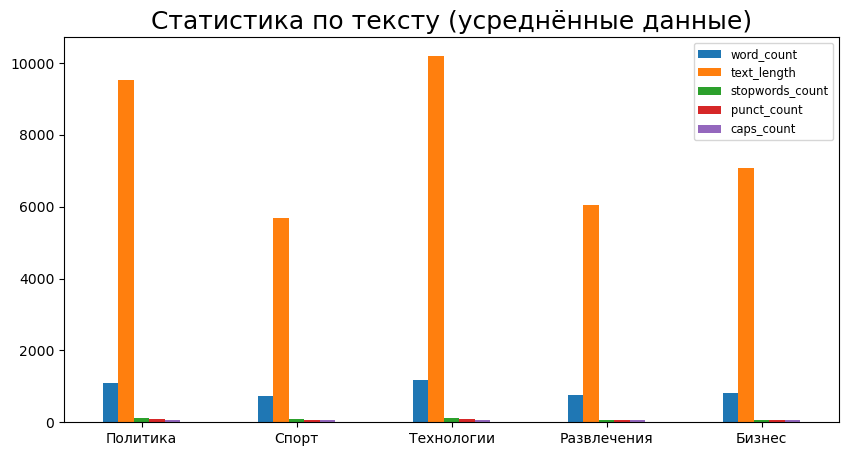

In [131]:
fig, ax=plt.subplots(figsize=(10,5))
grouped_text.plot(kind="bar", ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"])
ax.set_title("Статистика по тексту (усреднённые данные)", fontsize=18)
ax.legend(fontsize="small")
plt.xticks(rotation=0)
plt.show()

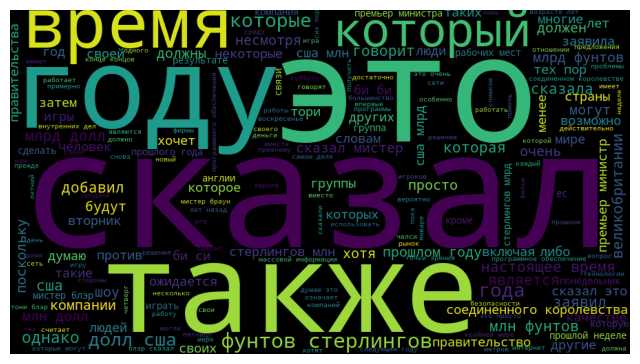

In [132]:
all_cleaned_text = " ".join(df["cleaned_text"])
word_cld = WordCloud(width=900, height=500).generate(all_cleaned_text)
plt.figure(figsize=(8,6))
plt.imshow(word_cld)
plt.axis("off")
plt.show()

## CountVectorizer

In [133]:
count_vec = CountVectorizer(max_features=5000)
count_array = count_vec.fit_transform(df["cleaned_text"]).toarray()
df_count_vec = pd.DataFrame(count_array, columns=count_vec.get_feature_names_out())
df_count_vec = df_count_vec.reset_index(drop=True)
df_count_vec.head()

,абсолютно,аварии,августа,августе,авиакомпании,авиакомпаний,авиакомпания,авиатор,австралии,австралийский,...,ян,январе,января,янг,японии,япония,японская,японский,ярдов,ясно
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


In [134]:
df1 = df.iloc[:, [1,3,4,5,6,7]]
df1 = df1.reset_index(drop=True)
df1.head()

,Label,word_count,text_length,stopwords_count,punct_count,caps_count
0,0,1360,11848,108,86,57
1,0,1140,10126,106,83,46
2,0,1312,11237,123,109,63
3,0,1348,12237,131,81,56
4,0,1084,9017,106,96,109


In [135]:
df_nlp = pd.concat([df1, df_count_vec], axis=1)
df_nlp.head()

,Label,word_count,text_length,stopwords_count,punct_count,caps_count,абсолютно,аварии,августа,августе,...,ян,январе,января,янг,японии,япония,японская,японский,ярдов,ясно
0,0,1360,11848,108,86,57,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1140,10126,106,83,46,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1312,11237,123,109,63,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1348,12237,131,81,56,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1084,9017,106,96,109,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


## RandomUnderSampler

In [136]:
y = df_nlp["Label"]
X = df_nlp.drop("Label", axis=1)

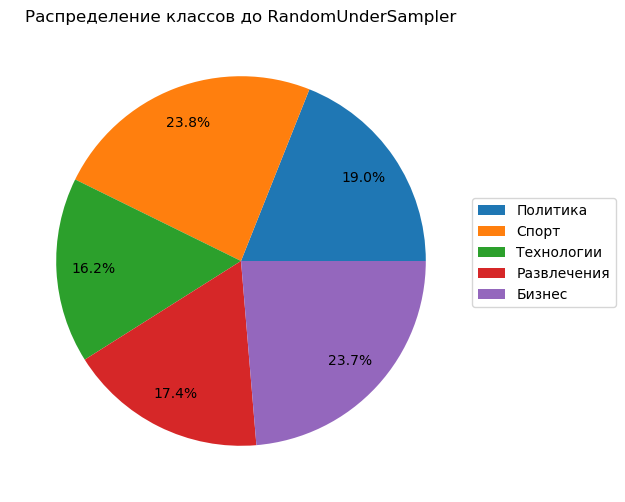

In [137]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов до RandomUnderSampler")
plt.show()

In [138]:
from imblearn.under_sampling import RandomUnderSampler
smote = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X, y = smote.fit_resample(X, y)

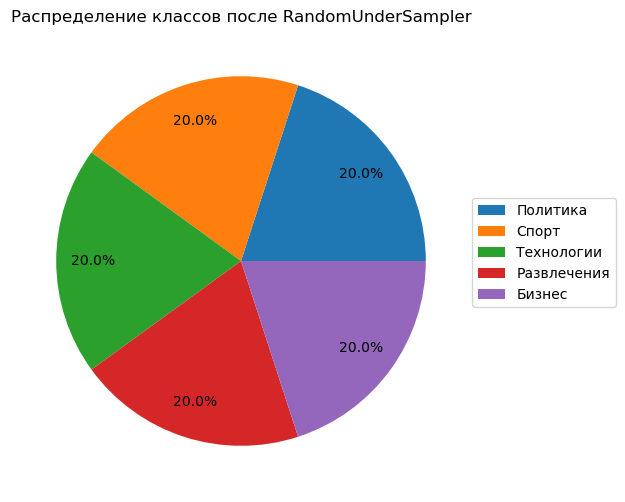

In [139]:
label_counts = y.value_counts().sort_index()

plt.figure(figsize=(6,6))
plt.pie(x=label_counts.values, autopct='%.1f%%', pctdistance=0.8)
plt.legend(labels=["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], loc=(1,0.4))
plt.title("Распределение классов после RandomUnderSampler")
plt.show()

In [140]:
print(X.shape)
print(y.shape)

(1725, 5005)
(1725,)


### train/test - разделение

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Стандартизация

In [142]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Модели

In [143]:
#######  Logistic Regression  #######
log = LogisticRegression().fit(X_train_scaled, y_train)
y_pred_log = log.predict(X_test_scaled)

#######  RandomForest  #######
rf = RandomForestClassifier().fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

#######  XGB Classifier  #######
xgb = XGBClassifier().fit(X_train_scaled, y_train)
y_pred_xgb = xgb.predict(X_test_scaled)

#######  LGBM Classifier  #######
lgbm = LGBMClassifier().fit(X_train_scaled, y_train)
y_pred_lgbm = lgbm.predict(X_test_scaled)

#######  CatBoost Classifier  #######
catb = CatBoostClassifier(verbose=False).fit(X_train_scaled, y_train)
y_pred_catb = catb.predict(X_test_scaled)

#######  PyTorch  #######
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_size = X_train_tensor.shape[1]
hidden_size = 64
num_classes = len(np.unique(y_train))
learning_rate = 0.001
num_epochs = 50

model = NeuralNetwork(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs, 1)
y_pred_pytorch = predicted.numpy()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10662
[LightGBM] [Info] Number of data points in the train set: 1207, number of used features: 2001
[LightGBM] [Info] Start training from score -1.574432
[LightGBM] [Info] Start training from score -1.644855
[LightGBM] [Info] Start training from score -1.598725
[LightGBM] [Info] Start training from score -1.611096
[LightGBM] [Info] Start training from score -1.619430
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


### Расчёт accuracy

In [144]:
accuracy_log = accuracy_score(y_test, y_pred_log)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)
accuracy_catb = accuracy_score(y_test, y_pred_catb)
accuracy_pytorch = accuracy_score(y_test, y_pred_pytorch)

## Результаты моделей

[0.9613899613899614, 0.9247104247104247, 0.9266409266409267, 0.944015444015444, 0.9459459459459459, 0.974903474903475]


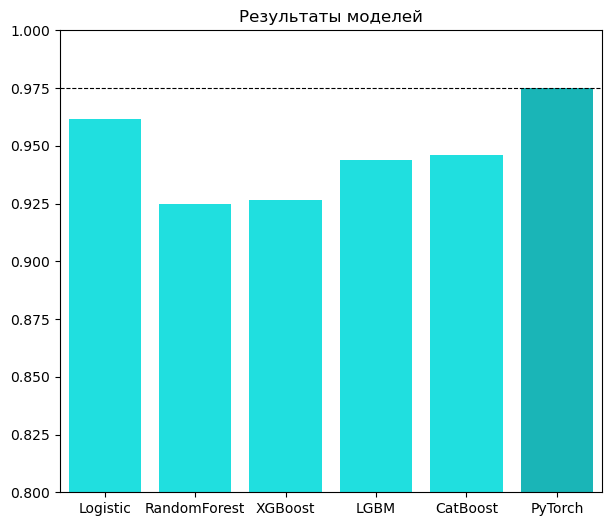

In [145]:
accuracy_list6 = [accuracy_log, accuracy_rf, accuracy_xgb, accuracy_lgbm, accuracy_catb, accuracy_pytorch]
fig, ax=plt.subplots(figsize=(7,6))
cols = ["aqua" if i < (max(accuracy_list6)) else "darkturquoise" for i in accuracy_list6]
sns.barplot(x=np.arange(0,6), y=accuracy_list6, ax=ax, palette=cols)
plt.ylim(0.8, 1)
plt.title("Результаты моделей")
plt.axhline(accuracy_pytorch, lw=0.8, ls="--", color="k")
ax.set_xticklabels(["Logistic", "RandomForest", "XGBoost", "LGBM", "CatBoost", "PyTorch"])
print(accuracy_list6)
plt.show()

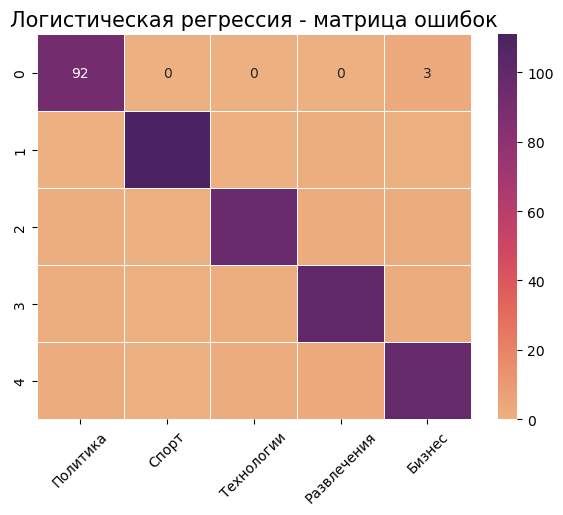

In [146]:
fig, ax=plt.subplots(figsize=(7,5))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, linewidths=0.4, cmap="flare", fmt='.3g', ax=ax)
ax.set_xticklabels(["Политика", "Спорт", "Технологии", "Развлечения", "Бизнес"], rotation=45)
ax.set_title("Логистическая регрессия - матрица ошибок", fontsize=15)
plt.show()

In [147]:
print(f"############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############\n\n {classification_report(y_test, y_pred_log)}")

############  КЛАССИФИКАЦИОННЫЙ ОТЧЕТ ЛОГИСТИЧЕСКОЙ РЕГРЕССИИ  ############

               precision    recall  f1-score   support

           0       0.96      0.97      0.96        95
           1       1.00      0.99      1.00       112
           2       0.97      0.95      0.96       101
           3       0.94      0.96      0.95       104
           4       0.93      0.93      0.93       106

    accuracy                           0.96       518
   macro avg       0.96      0.96      0.96       518
weighted avg       0.96      0.96      0.96       518



## Самое важное для LGBM

In [148]:
df_feature_importance = pd.DataFrame(lgbm.feature_importances_, columns=["feature_importance"])
df_feature_importance["features"] = df_nlp.columns[1:]
df_feature_importance = df_feature_importance.sort_values(by="feature_importance", ascending=False).reset_index(drop=True)
df_feature_importance.head()

,feature_importance,features
0,544,caps_count
1,533,text_length
2,444,stopwords_count
3,329,punct_count
4,256,word_count


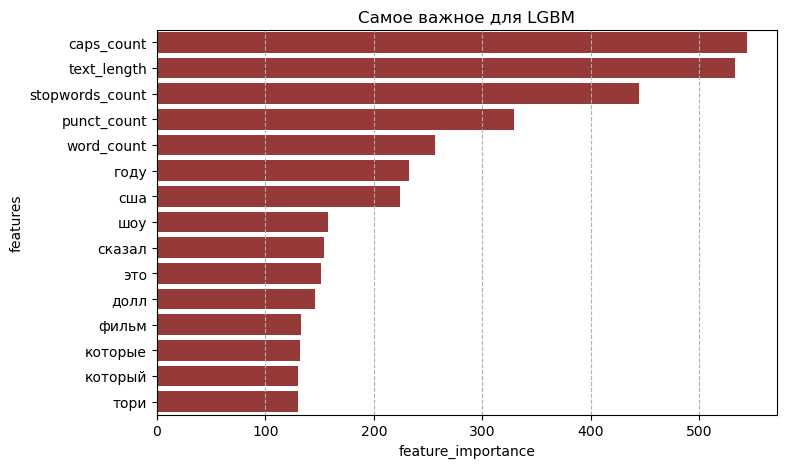

In [149]:
plt.figure(figsize=(8,5))
sns.barplot(x=df_feature_importance.feature_importance[:15], y=df_feature_importance.features[:15], color="brown")
plt.title("Самое важное для LGBM")
plt.grid(axis="x", ls="--")
plt.show()

## Результаты

Исследовав предложенные методы очистки текста на обучении 6 различных моделей, выяснилось, что самым эффективным методом является применение би-грамм и 4-грамм, так как n-граммы с другим n начинают переобучаться, следовательно, уменьшать необходимую нам accuracy, стемминг и лемматизация также уменьшают accuracy.

In [154]:
print(accuracy_list1)
print(accuracy_list2)
print(accuracy_list3)
print(accuracy_list4)
print(accuracy_list5)
print(accuracy_list6)

[0.9633204633204633, 0.9324324324324325, 0.9227799227799228, 0.9459459459459459, 0.944015444015444, 0.9652509652509652]
[0.9517374517374517, 0.9459459459459459, 0.9401544401544402, 0.9478764478764479, 0.9401544401544402, 0.9594594594594594]
[0.9575289575289575, 0.9517374517374517, 0.9362934362934363, 0.9459459459459459, 0.9517374517374517, 0.9633204633204633]
[0.9633204633204633, 0.9343629343629344, 0.9227799227799228, 0.9459459459459459, 0.9478764478764479, 0.9652509652509652]
[0.9613899613899614, 0.9343629343629344, 0.9285714285714286, 0.944015444015444, 0.9420849420849421, 0.9652509652509652]
[0.9613899613899614, 0.9247104247104247, 0.9266409266409267, 0.944015444015444, 0.9459459459459459, 0.974903474903475]
